This example demonstrated how to create a knowledge graph from diverse sources.
We'll use board member bios and financial news related to stocks as an example.
See the repo https://github.com/fastflair/StockPricePredictionFromFinancialFilings for algorithms to add structured data to the knoweldge graph

In [1]:
import sys
import re
import pandas as pd
from pandas import DataFrame
import datetime as DT
import numpy as np

from bs4 import BeautifulSoup
import urllib3 as u3
import json

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.stem.porter import *

import spacy
from spacy.lang.en import English
nlp_model = spacy.load('en_core_web_lg')
from spacy.matcher import Matcher 

from collections import Counter

We'll define a stock ticker symbol of interest

In [2]:
SYMBOL = "CVX"

In [3]:
triples = []
node_names = []

In [4]:
retries = u3.Retry(connect=2, read=1, redirect=10)
timeout = u3.Timeout(connect=10.0, read=40.0)
http = u3.PoolManager(retries=retries, timeout=timeout)
headers={'User-Agent': 'Mozilla/5.0'}
max_news = 9
max_days_old = 9
max_length_node_names = 50

In [5]:
# Let's filter our KG for nodes and edges of interest, those related to changes in information
Finance_words = ["increase", "decrease", "change", "less", "low", "big", "more", "forecast", "disruptions", "lower", "greater", "reduced", "hit"]
Finance_relationships = ["increase", "decrease", "less", "low", "big", "more", "change", "forecast", "greater", "lower", "reduced", "rises", "falls", "hit", "trend"]

In [6]:
# Since we don't want to type every possible variant of a word, we'll use a word stemmer
stemmer = PorterStemmer()
Finance_words_stemmed = []
Finance_relationships_stemmed = []
for token in Finance_words:
    Finance_words_stemmed.append(stemmer.stem(token))
for token in Finance_relationships:
    Finance_relationships_stemmed.append(stemmer.stem(token))

In [7]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        #printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    #print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (stemmer.stem(subject.strip()), stemmer.stem(relation.strip()), stemmer.stem(object.strip()))

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

In [8]:
def filter_graph(pairs, manynodes):
    k_graph = nx.from_pandas_edgelist(pairs, 'source', 'target',
            create_using=nx.MultiDiGraph())
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    for node in manynodes:
        edges = nx.dfs_successors(k_graph, node)
        nodes = []
        for k, v in edges.items():
            nodes.extend([k])
            nodes.extend(v)
        subgraph = k_graph.subgraph(nodes)
        layout = nx.spring_layout(k_graph, k=0.5, iterations=10)
        #layout = nx.spring_layout(k_graph)
        nx.draw_networkx(
            subgraph,
            node_size=1000,
            arrowsize=20,
            linewidths=1.5,
            pos=layout,
            edge_color='red',
            edgecolors='black',
            node_color='white'
            )
        labels = dict(zip((list(zip(pairs.source, pairs.target))),
                        pairs['edge'].tolist()))
        edges= tuple(subgraph.out_edges(data=False))
        sublabels ={k: labels[k] for k in edges}
    
        nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                               font_color='red')
    plt.axis('off')
    plt.title(SYMBOL+" financial impact knowledge graph")
    filename = "./"+SYMBOL.lower()+".png"
    plt.savefig(filename, dpi=(300), bbox_inches='tight')

In [9]:
# Let's get board member biographies by parsing the data from marketwatch.com
print("Getting company board member biographies.")
link = "https://www.marketwatch.com/investing/stock/"+SYMBOL.lower()+"/company-profile?mod=mw_quote_tab"
try:
    html = http.request('GET', link).data
except:
    html = ""
soup = BeautifulSoup(html, "lxml") 

Getting company board member biographies.


The code below uses a neural coreference server that can be implemented using the server.py code: https://github.com/fastflair/neuralcoref/tree/master/examples

In [10]:
person = []
title = []
hrefs = []
res = soup.findAll("li", {"class": "kv__item"})
for r in res:
    res2 = r.findAll("a", {"class": "primary link"})
    for r2 in res2:
        #print("Person: " + r.find("a", {'class': 'primary link'}).text)
        person.append(r.find("a", {'class': 'primary link'}).text)
    res3 = r.findAll("small", {"class": "label"})
    for r3 in res3:
        #print("Title: " + r.find("small", {'class': 'label'}).text)
        title.append(r.find("small", {'class': 'label'}).text)
    res4 = r.findAll("a", {"class": "primary link"}, href=True)
    for r4 in res4:
        #print("Person: " + r.find("a", {'class': 'primary link'}).text)
        hrefs.append( r4['href'])
        
texts_clean = ""
text_clean = []
for linkbio in hrefs:
    text_long = ""
    try:
        htmlbio = http.request('GET', linkbio).data
    except:
        htmlbio = ""
    soupbio = BeautifulSoup(htmlbio, "lxml")
    res = soupbio.findAll("p", {"class": "paragraph"})
    for r in res:
        text_long += r.text +" "
    try:
        url = "http://127.0.0.1:8000/?text='"+text_long.replace("&", "and")+"'"
        resp = http.request('GET', url)
        data = json.loads(resp.data.decode('utf-8'))
        texts_clean = texts_clean + data['resolved'] + " "
    except:
        texts_clean = texts_clean + text_long + " "
        
sentences = getSentences(texts_clean)
for sentence in sentences:
    triples.append(processSentence(sentence))

In [11]:
# Let's get news articles about the stock of interest
# Note that news should be added related to supply chain and business model information, such as from EIA.gov for energy stocks
print("Getting news articles about stock symbol from finviz.")
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

url = finviz_url + SYMBOL
#print(url)
try:
    resp = http.request('GET', url=url,headers=headers).data 
except:
    resp = ""
#resp = urlopen(req)    
html = BeautifulSoup(resp, features="lxml")
news_table = html.find(id='news-table')
news_tables[SYMBOL] = news_table

try:
   df = news_tables[SYMBOL]
   df_tr = df.findAll('tr')
    
   #print ('\n')
   #print ('Recent News Headlines for {}: '.format(SYMBOL))
        
   for i, table_row in enumerate(df_tr):
       a_text = table_row.a.text
       td_text = table_row.td.text
       td_text = td_text.strip()
       #print(a_text,'(',td_text,')')
       if i == max_news-1:
           break
except:
    pass

# Iterate through the news
parsed_news = []
hrefs = []
text = ""
for file_name, news_table in news_tables.items():
    try:
        for x in news_table.findAll('tr'):
            text = x.a.get_text()
            date_scrape = x.td.text.split()

            if len(date_scrape) == 1:
                #time = date_scrape[0]
                if "fiction" not in x.a['href']:
                    hrefs.append( x.a['href'])
            else:
                date = date_scrape[0]
                date_time_obj = DT.datetime.strptime(date, '%b-%d-%y')
                today = DT.datetime.now() 
                week_ago = today - DT.timedelta(days=max_days_old)
                if date_time_obj > week_ago:
                    if "fiction" not in x.a['href']:
                        hrefs.append( x.a['href'])
                else:
                    pass
    except:
        print("pass")
        pass

count = 0
texts_clean = ""
text_clean = []
for url in hrefs:
    #print(url)
    try:
        html = http.request('GET', url, headers=headers).data 
    except:
        html = ""
    #html = urlopen(req).read()
    soup = BeautifulSoup(html, "lxml")
    
    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out

    # get text
    text = soup.get_text(strip=True)

    # break into lines and remove leading and trailing space on each
    #lines = (line.strip() for line in text.splitlines())
    text_long = ""
    for sentence in getSentences(text):
        text_long += sentence +" "
    try:
        url = "http://127.0.0.1:8000/?text='"+text_long.replace("&", "and")+"'"
        resp = http.request('GET', url)
        data = json.loads(resp.data.decode('utf-8'))
        texts_clean = texts_clean + data['resolved'] + " "
    except:
        texts_clean = texts_clean + text_long + " "
        
    for sentence in getSentences(texts_clean):
        text_clean.append(sentence)

    count = count+1
    if count > max_news-1:
        break
        
sentences = getSentences(texts_clean)
for sentence in sentences:
    triples.append(processSentence(sentence))

Getting news articles about stock symbol from finviz.


In [12]:
# Build and clean the KG from a dataframe
df=DataFrame(triples, columns=['source', 'target', 'edge'])
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df['source'].replace('', np.nan, inplace=True)
df['target'].replace('', np.nan, inplace=True)
df['edge'].replace('', np.nan, inplace=True)
df.dropna(subset=['source'], inplace=True)
df.dropna(subset=['target'], inplace=True)
df.dropna(subset=['edge'], inplace=True)
kg_df = df

In [13]:
# Filter the KG (very large) for only nodes/edges related to the topic of interest. 
# In this case it's information related to changes in known trends
#print(kg_df.to_string())
#build list of node names
node_names = []
kg_df['source'] = kg_df.source.astype(str)
for words1 in kg_df['source']:
        if len(words1) < max_length_node_names:
            for word1 in words1.split():
                for word2 in Finance_words_stemmed:
                    if word1.lower() == word2.lower():
                        if words1 not in node_names:
                            node_names.append(words1)
kg_df['target'] = kg_df.target.astype(str)
for words1 in kg_df['target']:
    if len(words1) < max_length_node_names:
        for word1 in words1.split():
            for word2 in Finance_words_stemmed:
                if word1.lower() == word2.lower():
                    if words1 not in node_names:
                        node_names.append(words1)
kg_df['edge'] = kg_df.edge.astype(str)
for ind in kg_df.index: 
    for word1 in kg_df['edge'][ind].split():
        if len(words1) < max_length_node_names:
            for word2 in Finance_relationships_stemmed:
                if word1.lower() == word2.lower():
                    if kg_df['source'][ind] not in node_names:
                        node_names.append(kg_df['source'][ind])
                    if kg_df['target'][ind] not in node_names:
                        node_names.append(kg_df['target'][ind])

Creating knowledge graph image.


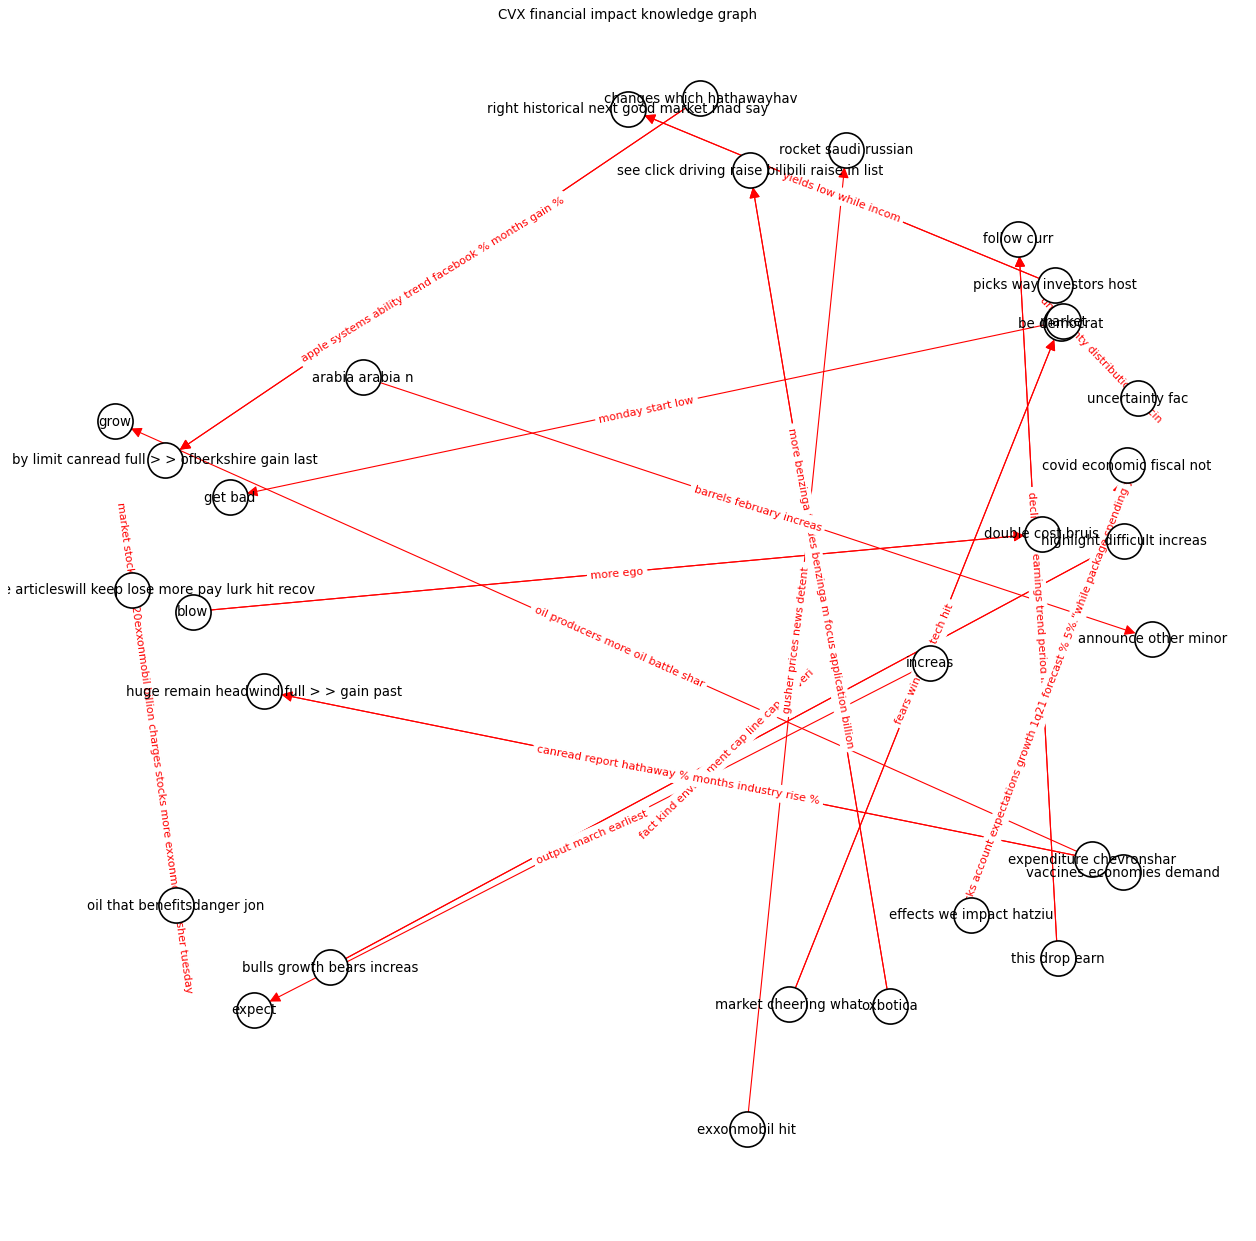

In [14]:
print("Creating knowledge graph image.")
filter_graph(kg_df, node_names)

Let's build a node2vec model from the networkX KG

In [15]:
from node2vec import Node2Vec

In [16]:
# build graph
G_data = nx.from_pandas_edgelist(kg_df, "source", "target", create_using=nx.Graph())

In [17]:
# Generate walks using 6 CPU cores
node2vec = Node2Vec(G_data, dimensions=50, walk_length=16, num_walks=200, workers=6)

In [18]:
# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

In [20]:
from sklearn.manifold import TSNE

In [24]:
# Retrieve node embeddings and corresponding subjects
node_ids = n2w_model.wv.index2word  # list of node IDs
node_embeddings = (
    n2w_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

In [35]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

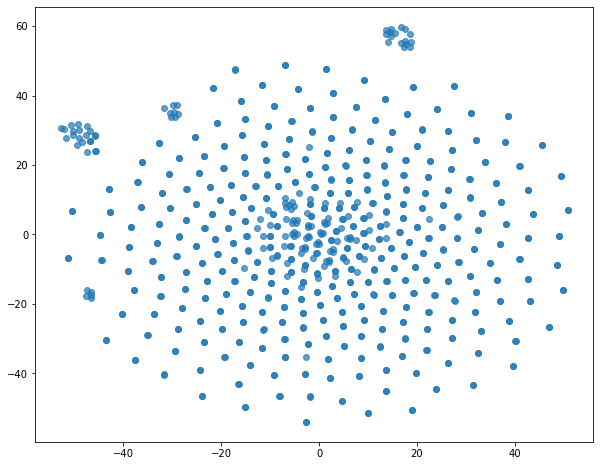

In [36]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    cmap="jet",
    alpha=alpha
)

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [40]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [41]:
tsne = TSNE(n_components=3)
node_embeddings_3d = tsne.fit_transform(node_embeddings)

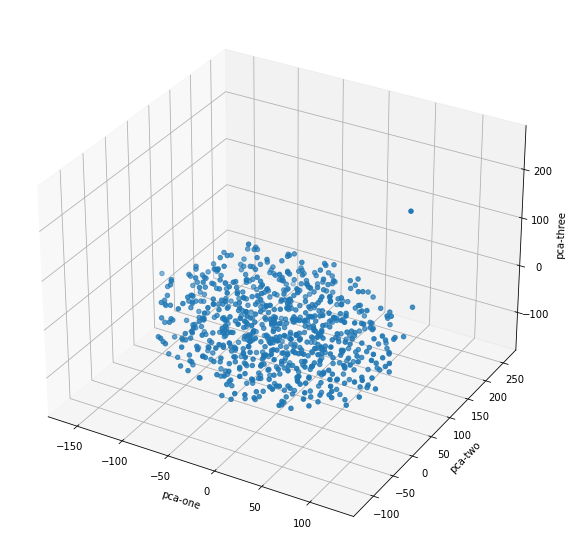

In [42]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=node_embeddings_3d[:, 0], 
    ys=node_embeddings_3d[:, 1], 
    zs=node_embeddings_3d[:, 2], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

<AxesSubplot:>

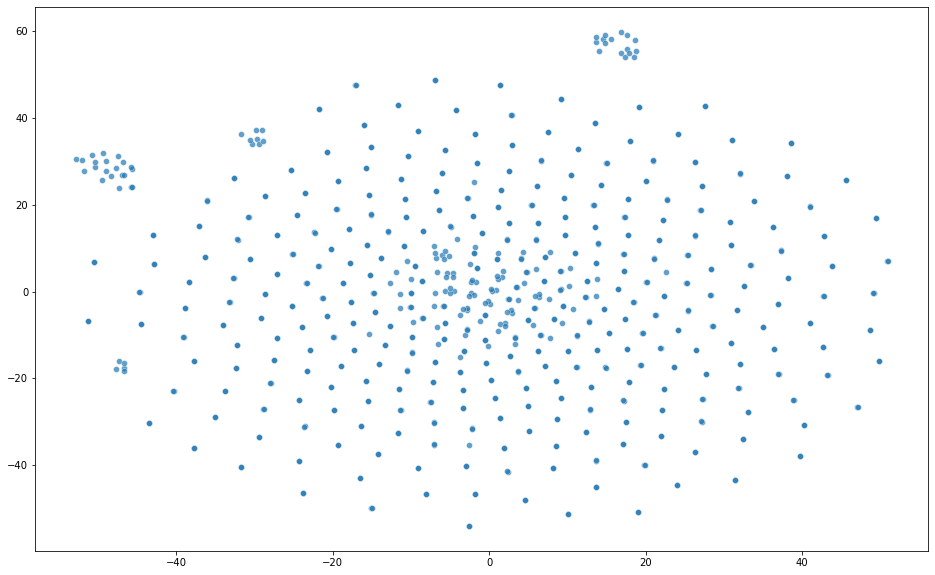

In [51]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=node_embeddings_2d[:,0], y=node_embeddings_2d[:,1],
    palette=sns.color_palette("hls", 10),
    data=node_embeddings_2d,
    legend="full",
    alpha=0.7
)